<a href="https://colab.research.google.com/github/prothman49/TorsionWingProject_public/blob/main/Phase4_code_torsion_wing_mirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Observability Analysis for Floppy Plate System - USING PYBOUNDS PROPERLY
Uses pybounds' SlidingEmpiricalObservabilityMatrix and SlidingFisherObservability

Author: Analysis of bio-inspired floppy plate dynamics
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint, solve_ivp
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 12.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-h8up3krp
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-h8up3krp
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=2615ca2cff54a98b21b76e28b4c37c8de31e16d137e982d15b1c88dce0c79da5
  Stored in directory: /tmp/pip-ephem-wheel-cache-aou5g519/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


$\dot{\mathbf{x}} =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{q_1} \\[0.3em]
\bbox[yellow]{\dot{q}_1} \\[0.3em]
\bbox[yellow]{q_2} \\[0.3em]
\bbox[yellow]{\dot{q}_2} \\[0.3em]
\bbox[yellow]{\psi} \\[0.3em]
\bbox[yellow]{\dot{\psi}} \\[0.3em]
\bbox[yellow]{\Omega_x} \\[0.3em]
\bbox[yellow]{\Omega_y}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{q}_1} \\[0.3em]
-\bbox[lightblue]{\omega_1^2}\bbox[yellow]{q_1} - \bbox[lightblue]{2\zeta_1\omega_1}\bbox[yellow]{\dot{q}_1} + \bbox[lightblue]{k_1}\bbox[yellow]{(\Omega_x^2+\Omega_y^2)q_1} + \bbox[lightblue]{k_1}\bbox[yellow]{\Omega_x \dot{\psi}} \\[0.3em]
\bbox[yellow]{\dot{q}_2} \\[0.3em]
-\bbox[lightblue]{\omega_2^2}\bbox[yellow]{q_2} - \bbox[lightblue]{2\zeta_2\omega_2}\bbox[yellow]{\dot{q}_2} + \bbox[lightblue]{k_2}\bbox[yellow]{(\Omega_x^2+\Omega_y^2)q_2} + \bbox[lightblue]{k_2}\bbox[yellow]{\Omega_y \dot{\psi}} \\[0.3em]
\bbox[yellow]{\dot{\psi}} \\[0.3em]
-\bbox[lightblue]{\omega_\psi^2}\bbox[yellow]{\psi} - \bbox[lightblue]{2\zeta_\psi\omega_\psi}\bbox[yellow]{\dot{\psi}} + \bbox[lightblue]{k_\psi}\bbox[yellow]{\Omega_x \dot{q}_1} + \bbox[lightblue]{k_\psi}\bbox[yellow]{\Omega_y \dot{q}_2} \\[0.3em]
-\bbox[lightblue]{\gamma_x}\bbox[yellow]{\Omega_x} \\[0.3em]
-\bbox[lightblue]{\gamma_y}\bbox[yellow]{\Omega_y}
\end{bmatrix}} +
\overset{g_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{\alpha_1} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{\alpha_2} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{u_1} +
\overset{g_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{\beta_\psi} \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{u_2} +
\overset{g_3}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{\rho_\Omega} \\[0.3em]
\bbox[lightblue]{\rho_\Omega}
\end{bmatrix}} \bbox[lightgreen]{u_3}
$

$
\mathbf{y} = \mathbf{h}(\mathbf{x}) =
\begin{bmatrix}
w(r_1(\mathbf{x})) \\[0.3em]
w(r_2(\mathbf{x})) \\[0.3em]
\theta(r_1(\mathbf{x})) \\[0.3em]
\theta(r_2(\mathbf{x}))
\end{bmatrix} =
\begin{bmatrix}
\bbox[lightblue]{\phi_1(r_1(\mathbf{x}))}\bbox[yellow]{q_1} + \bbox[lightblue]{\phi_2(r_1(\mathbf{x}))}\bbox[yellow]{q_2} + \bbox[lightblue]{\kappa_1}\bbox[yellow]{\psi q_1} \\[0.5em]
\bbox[lightblue]{\phi_1(r_2(\mathbf{x}))}\bbox[yellow]{q_1} + \bbox[lightblue]{\phi_2(r_2(\mathbf{x}))}\bbox[yellow]{q_2} + \bbox[lightblue]{\kappa_2}\bbox[yellow]{\psi q_2} \\[0.5em]
\bbox[lightblue]{\phi_\psi(r_1(\mathbf{x}))}\bbox[yellow]{\psi} \\[0.5em]
\bbox[lightblue]{\phi_\psi(r_2(\mathbf{x}))}\bbox[yellow]{\psi}
\end{bmatrix}
$

$
\begin{array}{ll}
\bbox[yellow]{\text{Yellow}} & \text{: Dynamic states (positions and velocities)} \\[0.3em]
\bbox[lightblue]{\text{Blue}} & \text{: Parameters (natural frequencies, damping, coupling coefficients)} \\[0.3em]
\bbox[lightgreen]{\text{Green}} & \text{: Control inputs}
\end{array}
$

$\text{States: } \bbox[yellow]{q_1, \dot{q}_1} \text{ (1st bending)}, \quad
\bbox[yellow]{q_2, \dot{q}_2} \text{ (2nd bending)}, \quad
\bbox[yellow]{\psi, \dot{\psi}} \text{ (torsional)}, \quad
\bbox[yellow]{\Omega_x, \Omega_y} \text{ (body rotation)}
$

$\text{Parameters: } \bbox[lightblue]{\omega_i, \zeta_i} \text{ (frequencies, damping)}, \quad
\bbox[lightblue]{k_i} \text{ (gyroscopic coupling)}, \quad
\bbox[lightblue]{\alpha_i, \beta_\psi, \rho_\Omega} \text{ (control coupling)}, \quad
\bbox[lightblue]{\gamma_x, \gamma_y} \text{ (body damping)}$

$\text{Controls: } \bbox[lightgreen]{u_1} \text{ (flapping, 25 Hz)}, \quad
\bbox[lightgreen]{u_2} \text{ (twisting, 3 Hz)}, \quad
\bbox[lightgreen]{u_3} \text{ (body rotation, 2 Hz)}$

$\text{Measurements: } w(r_1), w(r_2) \text{ (vertical displacements)}, \quad
\theta(r_1), \theta(r_2) \text{ (twist angles)}$

###System Parameters

In [ ]:

class FloppyPlateParams:
    """Parameters for the floppy plate system"""
    def __init__(self):
        # Modal natural frequencies [rad/s]
        self.omega_1 = 2 * np.pi * 5.0
        self.omega_2 = 2 * np.pi * 15.0
        self.omega_psi = 2 * np.pi * 10.0

        # Damping ratios
        self.zeta_1 = 0.02
        self.zeta_2 = 0.03
        self.zeta_psi = 0.025

        # Gyroscopic coupling
        self.k_1 = 0.1
        self.k_2 = 0.08
        self.k_psi = 0.15

        # Control coupling
        self.alpha_1 = 10.0
        self.alpha_2 = 5.0
        self.beta_psi = 8.0
        self.rho_Omega = 5.0

        # Damping
        self.gamma_x = 0.1
        self.gamma_y = 0.1

        # Geometry
        self.L = 0.2
        self.r_base_1 = 0.3
        self.r_base_2 = 0.7

        # Sensor location coupling (nonlinear!)
        self.eta_q = 0.05
        self.eta_psi = 0.03

        # Geometric coupling in measurements
        self.kappa_1 = 0.05
        self.kappa_2 = 0.05

        # Measurement noise standard deviations
        self.sigma_w = 0.002      # Displacement noise [m]
        self.sigma_theta = 0.01   # Angular noise [rad]

# Initialize parameters
params = FloppyPlateParams()

###Control Inputs

In [ ]:
def control_inputs(t: float) -> np.ndarray:
    """Multi-frequency control inputs"""
    amp_flap, freq_flap = 0.05, 25.0    # 25 Hz flapping
    amp_twist, freq_twist = 0.1, 3.0
    amp_body, freq_body = 0.5, 2.0

    u1 = amp_flap * np.sin(2 * np.pi * freq_flap * t)
    u2 = amp_twist * np.sin(2 * np.pi * freq_twist * t)
    u3 = amp_body * np.sin(2 * np.pi * freq_body * t)
    return np.array([u1, u2, u3])

##Dynamics Functions

In [ ]:
def dynamics_for_pybounds(t, x, u, params):
    """
    Dynamics function compatible with pybounds

    Args:
        t: time
        x: state dict with keys ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']
        u: control dict with keys ['u1', 'u2', 'u3']
        params: FloppyPlateParams object

    Returns:
        dx: state derivative dict
    """
    # Extract states
    q1 = x['q1']
    q1_dot = x['q1_dot']
    q2 = x['q2']
    q2_dot = x['q2_dot']
    psi = x['psi']
    psi_dot = x['psi_dot']
    Omega_x = x['Omega_x']
    Omega_y = x['Omega_y']

    # Extract controls
    u1 = u['u1']
    u2 = u['u2']
    u3 = u['u3']

    w1, w2, wp = params.omega_1, params.omega_2, params.omega_psi
    z1, z2, zp = params.zeta_1, params.zeta_2, params.zeta_psi
    k1, k2, kp = params.k_1, params.k_2, params.k_psi
    gx, gy = params.gamma_x, params.gamma_y

    Omega_squared = Omega_x**2 + Omega_y**2

    dx = {}
    dx['q1'] = q1_dot
    dx['q1_dot'] = -w1**2*q1 - 2*z1*w1*q1_dot + k1*Omega_squared*q1 + k1*Omega_x*psi_dot + params.alpha_1*u1
    dx['q2'] = q2_dot
    dx['q2_dot'] = -w2**2*q2 - 2*z2*w2*q2_dot + k2*Omega_squared*q2 + k2*Omega_y*psi_dot + params.alpha_2*u1
    dx['psi'] = psi_dot
    dx['psi_dot'] = -wp**2*psi - 2*zp*wp*psi_dot + kp*Omega_x*q1_dot + kp*Omega_y*q2_dot + params.beta_psi*u2
    dx['Omega_x'] = -gx*Omega_x + params.rho_Omega*u3
    dx['Omega_y'] = -gy*Omega_y + params.rho_Omega*u3

    return dx

def measurement_function(t, x, params, return_measurement_names=False):
    """
    Measurement function compatible with pybounds

    Returns dict with keys ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']
    """
    if return_measurement_names:
        return ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']

    q1 = x['q1']
    q2 = x['q2']
    psi = x['psi']

    # Compute sensor locations (state-dependent!)
    r1 = params.r_base_1 * params.L + params.eta_q * q1 + params.eta_psi * psi
    r2 = params.r_base_2 * params.L + params.eta_q * q2 + params.eta_psi * psi
    r1 = np.clip(r1, 0.1 * params.L, 0.9 * params.L)
    r2 = np.clip(r2, 0.1 * params.L, 0.9 * params.L)

    # Mode shapes
    r_norm = np.array([r1, r2]) / params.L
    phi1 = r_norm
    phi2 = r_norm**2 - 0.5 * r_norm
    phi_psi = r_norm

    y = {}
    y['w_r1'] = phi1[0]*q1 + phi2[0]*q2 + params.kappa_1*psi*q1
    y['w_r2'] = phi1[1]*q1 + phi2[1]*q2 + params.kappa_2*psi*q2
    y['theta_r1'] = phi_psi[0] * psi
    y['theta_r2'] = phi_psi[1] * psi

    return y

# Create shortcuts
f = dynamics_for_pybounds
h = measurement_function

##Measurement Check

In [ ]:
h(None, None, params, return_measurement_names=True)


['w_r1', 'w_r2', 'theta_r1', 'theta_r2']

### Define measurement noise characteritics for each measurement option in the measurement set  -- R Matrix

In [ ]:
measurement_noise_stds = {'w_r1': 0.0002,      # 2mm displacement noise now .2
                          'w_r2': 0.0002,      # 2mm displacement noise now .2
                          'theta_r1': 0.001,   # 0.01 rad angular noise now .001
                          'theta_r2': 0.001}   # 0.01 rad angular noise now .001

###Simulator Class

In [ ]:
class FloppyPlateSimulator:
    """Simulator class compatible with pybounds"""

    def __init__(self, params):
        self.params = params
        self.state_names = ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']
        self.measurement_names = ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']

    def f(self, t, x, u, aux=None):
        return dynamics_for_pybounds(t, x, u, self.params)

    def h(self, t, x, aux=None):
        return measurement_function(t, x, self.params)

    def simulate(self, x0, u, aux=None):
        # Convert x0 to array
        if isinstance(x0, dict):
            x0_arr = np.array([x0[name] for name in self.state_names])
        elif isinstance(x0, pd.Series):
            x0_arr = x0.values
        else:
            x0_arr = np.asarray(x0).flatten()

        # Handle u as DataFrame or array
        if isinstance(u, pd.DataFrame):
            u_array = u.values
            control_names = u.columns.tolist()
        else:
            u_array = np.asarray(u)
            if u_array.ndim == 1:
                u_array = u_array.reshape(-1, 1)
            control_names = ['u1', 'u2', 'u3']

        n_steps = len(u_array)
        t_sim = np.arange(n_steps)

        # Dynamics wrapper for scipy
        def dynamics_wrapper(t, x_arr):
            x_dict = {name: x_arr[i] for i, name in enumerate(self.state_names)}
            t_idx = int(np.clip(t, 0, n_steps-1))
            u_vals = u_array[t_idx]
            u_dict = {control_names[i]: u_vals[i] for i in range(len(control_names))}
            dx_dict = self.f(t, x_dict, u_dict)
            return np.array([dx_dict[name] for name in self.state_names])

        # Integrate
        sol = solve_ivp(
            dynamics_wrapper,
            [0, n_steps-1],
            x0_arr,
            t_eval=t_sim,
            method='RK45',
            rtol=1e-6,
            atol=1e-9
        )

        # Get measurements
        y_list = []
        for i, t in enumerate(sol.t):
            x_dict = {name: sol.y[j, i] for j, name in enumerate(self.state_names)}
            y_dict = self.h(t, x_dict)
            y_list.append(y_dict)

        return pd.DataFrame(y_list)

# Initialize simulator
simulator = FloppyPlateSimulator(params)

###Run Simulation

In [ ]:
def simulate_floppy_plate(dt=0.001, tsim_length=1.0):
    """Simulate the floppy plate system - FIXED VERSION"""

    t_span = (0.0, tsim_length)
    t_eval = np.arange(0, tsim_length, dt)
    x0 = np.array([0.001, 0.0, 0.0005, 0.0, 0.002, 0.0, 0.0, 0.0])

    # Dynamics for scipy
    def dynamics_array(t, x_arr):
        u = control_inputs(t)
        q1, q1_dot, q2, q2_dot, psi, psi_dot, Omega_x, Omega_y = x_arr

        w1, w2, wp = params.omega_1, params.omega_2, params.omega_psi
        z1, z2, zp = params.zeta_1, params.zeta_2, params.zeta_psi
        k1, k2, kp = params.k_1, params.k_2, params.k_psi
        gx, gy = params.gamma_x, params.gamma_y

        Omega_squared = Omega_x**2 + Omega_y**2

        f = np.zeros(8)
        f[0] = q1_dot
        f[1] = -w1**2*q1 - 2*z1*w1*q1_dot + k1*Omega_squared*q1 + k1*Omega_x*psi_dot + params.alpha_1*u[0]
        f[2] = q2_dot
        f[3] = -w2**2*q2 - 2*z2*w2*q2_dot + k2*Omega_squared*q2 + k2*Omega_y*psi_dot + params.alpha_2*u[0]
        f[4] = psi_dot
        f[5] = -wp**2*psi - 2*zp*wp*psi_dot + kp*Omega_x*q1_dot + kp*Omega_y*q2_dot + params.beta_psi*u[1]
        f[6] = -gx*Omega_x + params.rho_Omega*u[2]
        f[7] = -gy*Omega_y + params.rho_Omega*u[2]
        return f

    # Integrate
    sol = solve_ivp(
        dynamics_array,
        t_span,
        x0,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-6,
        atol=1e-9
    )

    t_sim = sol.t
    x_arr = sol.y.T

    # Create DataFrames
    state_names = ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']
    x_sim = pd.DataFrame(x_arr, columns=state_names)

    # FIX: Create u_sim by evaluating control_inputs at each time point
    print("Creating control trajectory...")
    u_list = []
    for ti in t_sim:
        u_i = control_inputs(ti)
        u_list.append(u_i)
    u_arr = np.array(u_list)
    u_sim = pd.DataFrame(u_arr, columns=['u1', 'u2', 'u3'])

    # Verify controls are correct
    print(f"  u1 range: {np.ptp(u_sim['u1'].values):.6e} m (should be ~0.02)")
    print(f"  u2 range: {np.ptp(u_sim['u2'].values):.6e} rad (should be ~0.2)")
    print(f"  u3 range: {np.ptp(u_sim['u3'].values):.6e} (should be ~1.0)")

    # Get measurements
    y_list = []
    for i in range(len(t_sim)):
        x_dict = x_sim.iloc[i].to_dict()
        y_dict = measurement_function(t_sim[i], x_dict, params)
        y_list.append(y_dict)
    y_sim = pd.DataFrame(y_list)

    return t_sim, x_sim, u_sim, y_sim, simulator

In [ ]:
# Run simulation with FIXED function
t_sim, x_sim, u_sim, y_sim, simulator = simulate_floppy_plate(dt=0.005, tsim_length=1.0)

print(f"\n✓ Simulated {len(t_sim)} time steps")
print("\nState ranges:")
for state in ['q1', 'q2', 'psi', 'Omega_x']:
    print(f"  {state}: {np.ptp(x_sim[state].values):.4e}")

Creating control trajectory...
  u1 range: 1.000000e-01 m (should be ~0.02)
  u2 range: 2.000000e-01 rad (should be ~0.2)
  u3 range: 1.000000e+00 (should be ~1.0)

✓ Simulated 200 time steps

State ranges:
  q1: 1.9385e-03
  q2: 9.4350e-04
  psi: 3.6744e-03
  Omega_x: 4.1150e-01


###Plot the modal coordinates

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

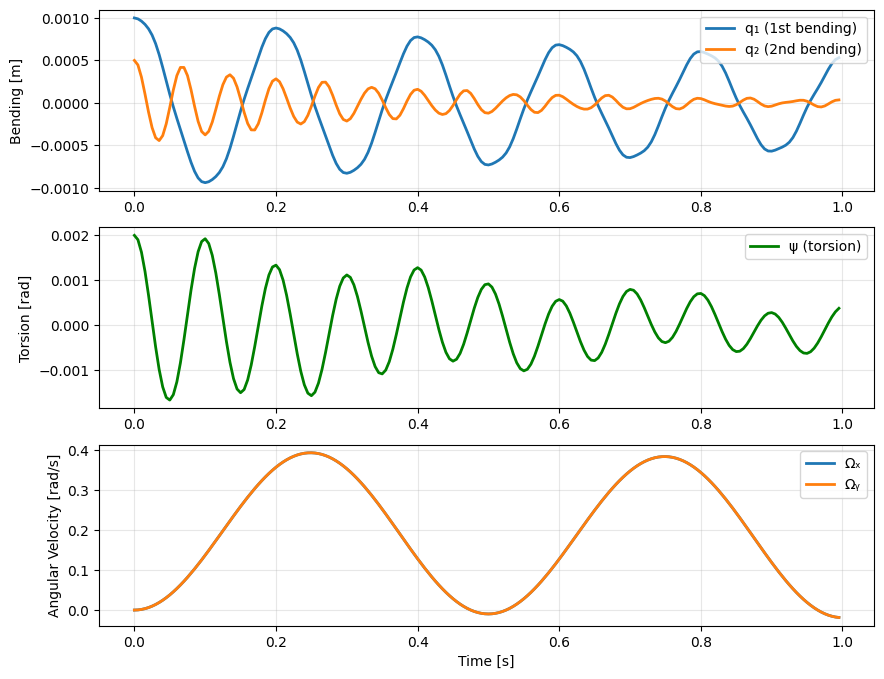

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Bending modes
axes[0].plot(t_sim, x_sim['q1'], label='q₁ (1st bending)', linewidth=2)
axes[0].plot(t_sim, x_sim['q2'], label='q₂ (2nd bending)', linewidth=2)
axes[0].set_ylabel('Bending [m]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Torsional mode
axes[1].plot(t_sim, x_sim['psi'], label='ψ (torsion)', linewidth=2, color='green')
axes[1].set_ylabel('Torsion [rad]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Body angular velocities
axes[2].plot(t_sim, x_sim['Omega_x'], label='Ωₓ', linewidth=2)
axes[2].plot(t_sim, x_sim['Omega_y'], label='Ωᵧ', linewidth=2)
axes[2].set_ylabel('Angular Velocity [rad/s]')
axes[2].set_xlabel('Time [s]')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout

###Plot Measurements

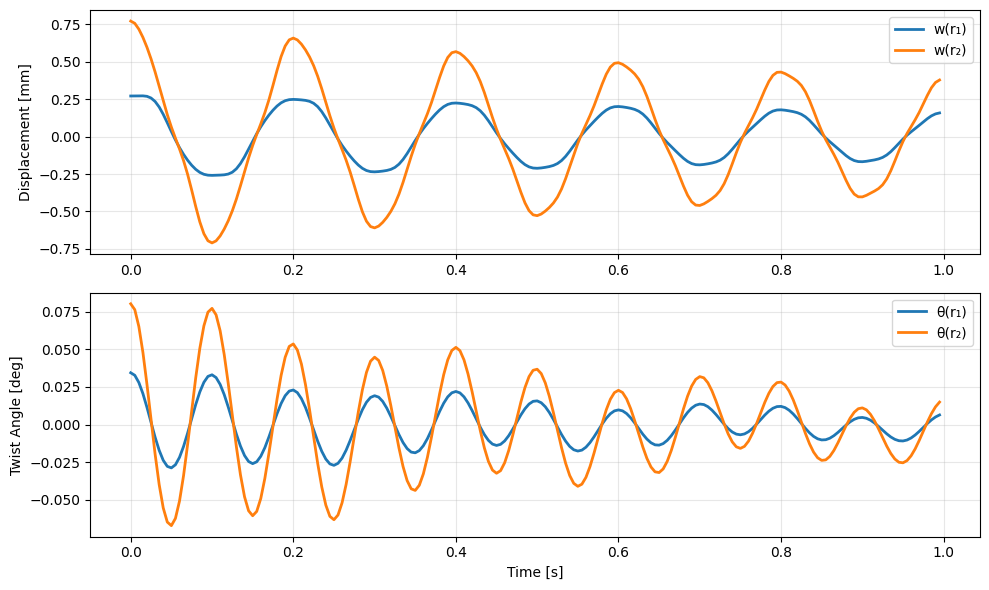

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Displacement measurements
axes[0].plot(t_sim, y_sim['w_r1']*1000, label='w(r₁)', linewidth=2)
axes[0].plot(t_sim, y_sim['w_r2']*1000, label='w(r₂)', linewidth=2)
axes[0].set_ylabel('Displacement [mm]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Angular measurements
axes[1].plot(t_sim, np.degrees(y_sim['theta_r1']), label='θ(r₁)', linewidth=2)
axes[1].plot(t_sim, np.degrees(y_sim['theta_r2']), label='θ(r₂)', linewidth=2)
axes[1].set_ylabel('Twist Angle [deg]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###Save Data as Dataframes

In [ ]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

###Observability Analysis

In [ ]:
w = 6  # window size


###Construct O in Sliding Windows

In [ ]:
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(
    simulator, t_sim, x_sim, u_sim,
    w=w, eps=1e-4,
    parallel_sliding=True  # Enable parallel processing
)

# Get O's
O_sliding = SEOM.get_observability_matrix()

n_window = len(O_sliding)
print(n_window, 'windows')

195 windows


In [ ]:
import pickle

# Save the SEOM object
with open('seom.pkl', 'wb') as f:
    pickle.dump(SEOM, f)

# Save the o_sliding variable
with open('o_sliding.pkl', 'wb') as f:
    pickle.dump(O_sliding, f)

print("SEOM object saved to seom.pkl")
print("o_sliding variable saved to o_sliding.pkl")

###View Observability Matrix

In [ ]:
O_sliding[0]

,,q1,q1_dot,q2,q2_dot,psi,psi_dot,Omega_x,Omega_y
sensor,time_step,,,,,,,,
w_r1,0,3.009126e-01,0.000000e+00,-5.994470e-02,0.000000e+00,2.075825e-04,0.000000e+00,0.000000e+00,0.000000e+00
w_r2,0,7.004250e-01,0.000000e+00,1.408453e-01,0.000000e+00,2.425638e-04,0.000000e+00,0.000000e+00,0.000000e+00
theta_r1,0,5.000000e-04,0.000000e+00,0.000000e+00,0.000000e+00,3.008500e-01,0.000000e+00,0.000000e+00,0.000000e+00
theta_r2,0,0.000000e+00,0.000000e+00,5.000000e-04,0.000000e+00,7.007250e-01,0.000000e+00,0.000000e+00,0.000000e+00
w_r1,1,1.602101e-01,-3.205606e-05,-3.540809e-03,1.598833e-06,2.226173e-05,-6.704361e-09,2.331745e-08,-7.199987e-10
w_r2,1,3.734245e-01,-7.471761e-05,8.277821e-03,-3.739860e-06,1.773197e-05,-6.370574e-09,5.434247e-08,1.636444e-09
theta_r1,1,5.545467e-05,-1.109109e-08,4.061039e-07,-2.022804e-08,6.237436e-02,-1.951392e-05,2.830070e-09,5.096793e-09
theta_r2,1,1.174328e-07,-1.252389e-11,7.078566e-06,-4.993623e-08,1.454426e-01,-4.550194e-05,6.580264e-09,1.188578e-08
w_r1,2,8.542481e-02,-3.428628e-05,-2.085927e-04,1.839274e-07,3.213326e-06,-7.377738e-08,2.871974e-08,7.437399e-09


### Convert a single observability matrix into fisher information

$F = \mathcal{O}_w^T R_w^{-1} \mathcal{O}_w$

In [ ]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

# Compute the Fisher information & Chernoff inverse
SFO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

# Get the Fisher information, inverse, and R matrix
F, F_inv, R = SFO.get_fisher_information()
F_inv

,q1,q1_dot,q2,q2_dot,psi,psi_dot,Omega_x,Omega_y
q1,1.212057e-07,0.000354,-4.170993e-07,0.002837,-1.282825e-09,-0.000080,3.829123e-02,2.652177e-02
q1_dot,3.543362e-04,5.418418,-1.222926e-03,-37.443523,-1.420103e-05,-1.243141,2.120607e+03,-1.532707e+03
q2,-4.170993e-07,-0.001223,3.142488e-06,-0.005953,1.776044e-09,0.000263,-1.317004e-01,-8.928267e-02
q2_dot,2.836935e-03,-37.443523,-5.953479e-03,3079.233151,1.230268e-04,10.687690,-6.801053e+03,-1.380062e+03
psi,-1.282825e-09,-0.000014,1.776044e-09,0.000123,1.716724e-06,0.005067,3.884669e-03,-3.143848e-02
psi_dot,-8.030124e-05,-1.243141,2.625064e-04,10.687690,5.066821e-03,361.146738,4.164490e+02,-3.409997e+03
Omega_x,3.829123e-02,2120.607048,-1.317004e-01,-6801.052706,3.884669e-03,416.448983,2.187357e+06,-2.827205e+06
Omega_y,2.652177e-02,-1532.707140,-8.928267e-02,-1380.061519,-3.143848e-02,-3409.996794,-2.827205e+06,6.019091e+06


###Efficiently repeat the above process for a specific set of sensors, states, and time points

In [ ]:
# Choose sensors to use from O
o_sensors = h(None, None, params, return_measurement_names=True)  # ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']

# Chose states to use from O
o_states = ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']

# Choose time-steps to use from O
window_size = 6  # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = pybounds.SlidingFisherObservability(
    SEOM.O_df_sliding,
    time=SEOM.t_sim,
    lam=1e-8,
    R=o_measurement_noise_vars,
    states=o_states,
    sensors=o_sensors,
    time_steps=o_time_steps,
    w=None
)

# If you want to manually inspect one of the fisher info matrices:
# SFO.FO[1].O

# Pull out minimum error variance
EV_aligned = SFO.get_minimum_error_variance()
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1562065509.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


###Plot Observability over time

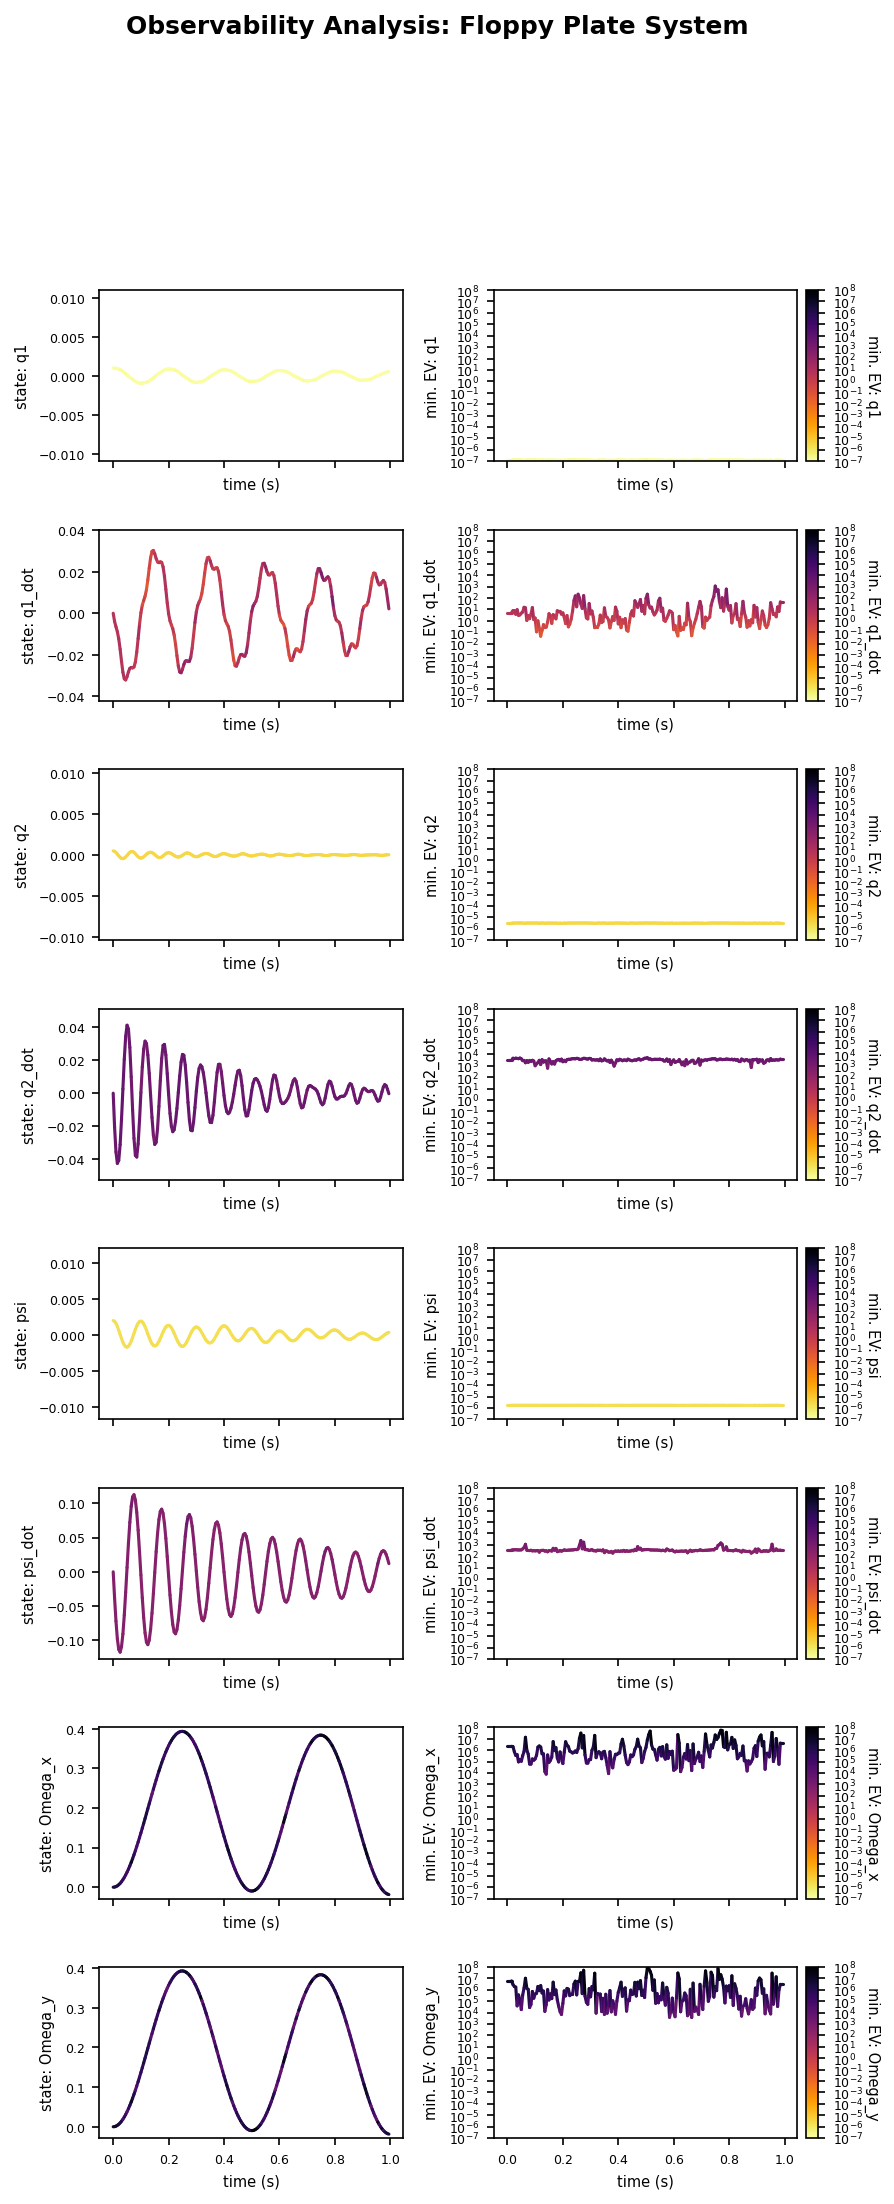

In [ ]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.01, x_max + 0.01)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.suptitle('Observability Analysis: Floppy Plate System', fontsize=12, fontweight='bold', y=0.995)
plt.show()


###Inspect Observability Matrices

In [ ]:

print("="*70)
print("OBSERVABILITY MATRIX ANALYSIS")
print("="*70)

# Get the first observability matrix
O_first = SFO.FO[0].O
print(f"\n1. First Observability Matrix Shape: {O_first.shape}")
print(f"   States (columns): {list(O_first.columns)}")
print(f"   Measurements × time steps (rows): {O_first.shape[0]}")

# Display the matrix
print("\nFirst Observability Matrix (first 10 rows):")
print(O_first.head(10))


OBSERVABILITY MATRIX ANALYSIS

1. First Observability Matrix Shape: (24, 8)
   States (columns): ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']
   Measurements × time steps (rows): 24

First Observability Matrix (first 10 rows):
                              q1        q1_dot            q2        q2_dot  \
sensor   time_step                                                           
theta_r1 0          5.000000e-04  0.000000e+00  0.000000e+00  0.000000e+00   
theta_r2 0          0.000000e+00  0.000000e+00  5.000000e-04  0.000000e+00   
w_r1     0          3.009126e-01  0.000000e+00 -5.994470e-02  0.000000e+00   
w_r2     0          7.004250e-01  0.000000e+00  1.408453e-01  0.000000e+00   
theta_r1 1          5.545467e-05 -1.109109e-08  4.061039e-07 -2.022804e-08   
theta_r2 1          1.174328e-07 -1.252389e-11  7.078566e-06 -4.993623e-08   
w_r1     1          1.602101e-01 -3.205606e-05 -3.540809e-03  1.598833e-06   
w_r2     1          3.734245e-01 -7.471761e

###Rank Analysis


RANK ANALYSIS

Number of windows: 195
Rank statistics:
  Min rank: 8
  Max rank: 8
  Mean rank: 8.00
  Full rank (=8): 195 windows

Condition number statistics (lower is better):
  Min: 5.33e+05
  Max: 1.08e+08
  Mean: 7.51e+06


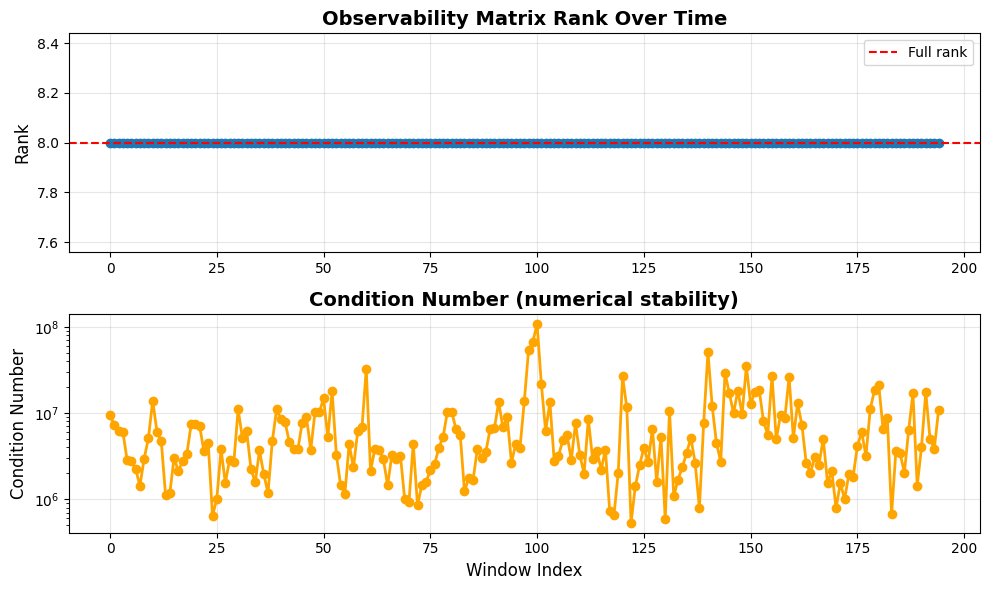

In [ ]:
print("\n" + "="*70)
print("RANK ANALYSIS")
print("="*70)

ranks = []
condition_numbers = []

for i, FO in enumerate(SFO.FO):
    O = FO.O.values
    rank = np.linalg.matrix_rank(O)
    ranks.append(rank)

    cond = np.linalg.cond(O)
    condition_numbers.append(cond)

print(f"\nNumber of windows: {len(ranks)}")
print(f"Rank statistics:")
print(f"  Min rank: {np.min(ranks)}")
print(f"  Max rank: {np.max(ranks)}")
print(f"  Mean rank: {np.mean(ranks):.2f}")
print(f"  Full rank (={len(SFO.FO[0].O.columns)}): {np.sum(np.array(ranks) == len(SFO.FO[0].O.columns))} windows")

print(f"\nCondition number statistics (lower is better):")
print(f"  Min: {np.min(condition_numbers):.2e}")
print(f"  Max: {np.max(condition_numbers):.2e}")
print(f"  Mean: {np.mean(condition_numbers):.2e}")

# Plot rank over time
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(ranks, 'o-', linewidth=2)
axes[0].axhline(y=len(SFO.FO[0].O.columns), color='r', linestyle='--', label='Full rank')
axes[0].set_ylabel('Rank', fontsize=12)
axes[0].set_title('Observability Matrix Rank Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(condition_numbers, 'o-', linewidth=2, color='orange')
axes[1].set_ylabel('Condition Number', fontsize=12)
axes[1].set_xlabel('Window Index', fontsize=12)
axes[1].set_title('Condition Number (numerical stability)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###Error Variance Analysis

In [ ]:
print("\n" + "="*70)
print("ERROR VARIANCE ANALYSIS")
print("="*70)

print("\nError Variance Statistics (for each state):")
print("-"*70)

state_names = [col for col in EV_no_nan.columns if col not in ['time', 'time_initial']]

for state in state_names:
    ev_state = EV_no_nan[state].values
    ev_state_clean = ev_state[np.isfinite(ev_state)]

    print(f"\n{state}:")
    print(f"  Min:    {np.min(ev_state_clean):.4e}")
    print(f"  Max:    {np.max(ev_state_clean):.4e}")
    print(f"  Mean:   {np.mean(ev_state_clean):.4e}")
    print(f"  Median: {np.median(ev_state_clean):.4e}")
    print(f"  Std:    {np.std(ev_state_clean):.4e}")


ERROR VARIANCE ANALYSIS

Error Variance Statistics (for each state):
----------------------------------------------------------------------

q1:
  Min:    1.0460e-07
  Max:    1.3144e-07
  Mean:   1.2397e-07
  Median: 1.2605e-07
  Std:    6.5573e-09

q1_dot:
  Min:    4.6084e-02
  Max:    1.1339e+03
  Mean:   2.8140e+01
  Median: 3.3586e+00
  Std:    1.0506e+02

q2:
  Min:    3.0015e-06
  Max:    3.2903e-06
  Mean:   3.2011e-06
  Median: 3.2204e-06
  Std:    7.4383e-08

q2_dot:
  Min:    6.1931e+02
  Max:    5.1193e+03
  Mean:   3.1479e+03
  Median: 3.2732e+03
  Std:    8.6345e+02

psi:
  Min:    1.6848e-06
  Max:    1.7243e-06
  Mean:   1.7123e-06
  Median: 1.7154e-06
  Std:    9.0764e-09

psi_dot:
  Min:    1.8919e+02
  Max:    2.4227e+03
  Mean:   3.7786e+02
  Median: 3.2990e+02
  Std:    2.3726e+02

Omega_x:
  Min:    8.0301e+03
  Max:    5.6175e+07
  Mean:   3.7490e+06
  Median: 6.6314e+05
  Std:    8.7538e+06

Omega_y:
  Min:    3.7533e+03
  Max:    8.7341e+07
  Mean:   4.2698e+

###Relative Observability


RELATIVE OBSERVABILITY (lower error variance = better observability)

States ranked by observability (best to worst):
  1. q1          : 1.2397e-07
  2. psi         : 1.7123e-06
  3. q2          : 3.2011e-06
  4. q1_dot      : 2.8140e+01
  5. psi_dot     : 3.7786e+02
  6. q2_dot      : 3.1479e+03
  7. Omega_x     : 3.7490e+06
  8. Omega_y     : 4.2698e+06


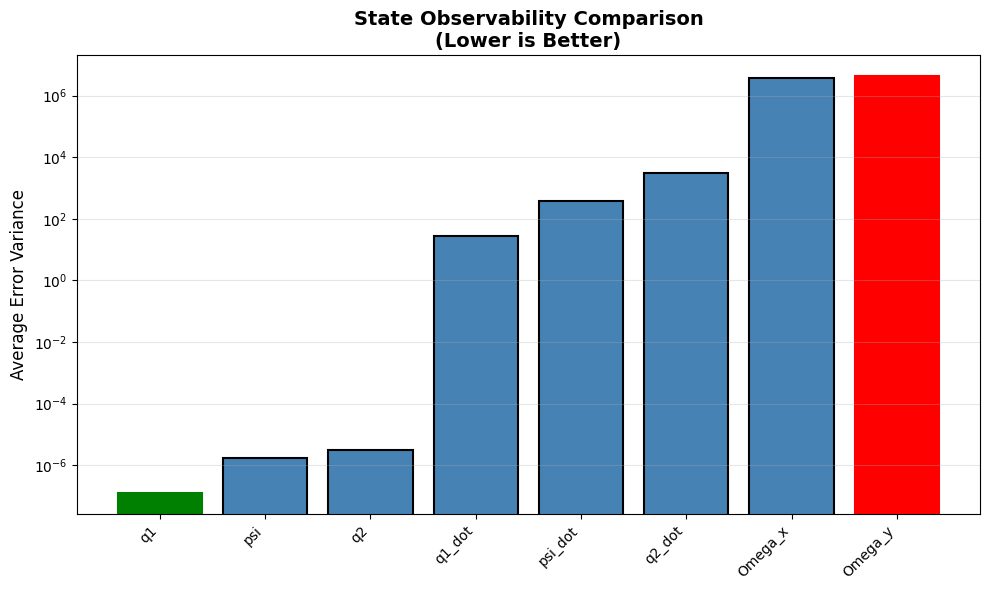

In [ ]:
print("\n" + "="*70)
print("RELATIVE OBSERVABILITY (lower error variance = better observability)")
print("="*70)

# Average error variance for each state
avg_ev = {state: np.mean(EV_no_nan[state].values[np.isfinite(EV_no_nan[state].values)])
          for state in state_names}

# Sort by observability
sorted_states = sorted(avg_ev.items(), key=lambda x: x[1])

print("\nStates ranked by observability (best to worst):")
for i, (state, ev) in enumerate(sorted_states):
    print(f"  {i+1}. {state:12s}: {ev:.4e}")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
states_plot = [s[0] for s in sorted_states]
evs_plot = [s[1] for s in sorted_states]

bars = ax.bar(range(len(states_plot)), evs_plot, color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_yscale('log')
ax.set_xticks(range(len(states_plot)))
ax.set_xticklabels(states_plot, rotation=45, ha='right')
ax.set_ylabel('Average Error Variance', fontsize=12)
ax.set_title('State Observability Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Color the best and worst
bars[0].set_color('green')
bars[-1].set_color('red')

plt.tight_layout()
plt.show()

###Singular Value Analysis


SINGULAR VALUE ANALYSIS (middle window)

Singular values of observability matrix (window 97):
  σ_1 = 9.0488e-01
  σ_2 = 7.7874e-01
  σ_3 = 1.2122e-01
  σ_4 = 1.3849e-04
  σ_5 = 5.2808e-05
  σ_6 = 3.6074e-06
  σ_7 = 2.3483e-07
  σ_8 = 6.6296e-08

Singular value ratios:
  σ_max / σ_min = 1.36e+07


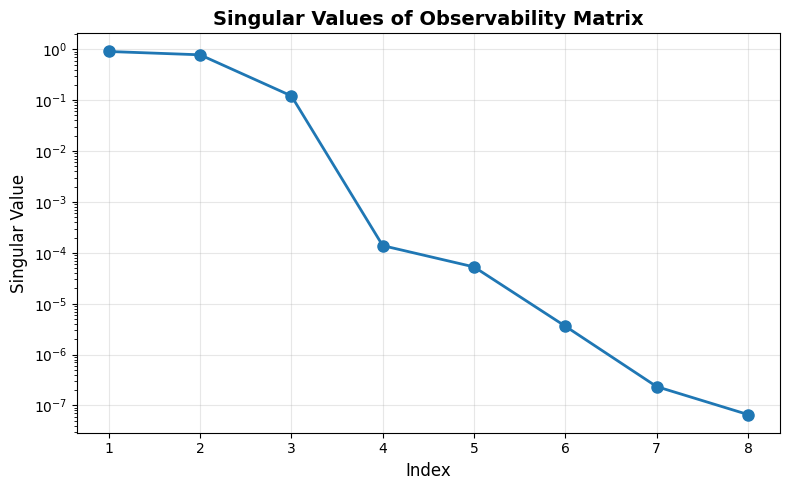

In [ ]:
print("\n" + "="*70)
print("SINGULAR VALUE ANALYSIS (middle window)")
print("="*70)

mid_idx = len(SFO.FO) // 2
O_mid = SFO.FO[mid_idx].O.values

U, s, Vt = np.linalg.svd(O_mid, full_matrices=False)

print(f"\nSingular values of observability matrix (window {mid_idx}):")
for i, sv in enumerate(s):
    print(f"  σ_{i+1} = {sv:.4e}")

print(f"\nSingular value ratios:")
print(f"  σ_max / σ_min = {s[0] / s[-1]:.2e}")

# Plot singular values
fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(range(1, len(s)+1), s, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Singular Value', fontsize=12)
ax.set_title('Singular Values of Observability Matrix', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

###Sensor Configuration Analysis -- Test Minimal Sensor Config

In [ ]:

print("\n" + "="*70)
print("MINIMAL SENSOR CONFIGURATION ANALYSIS")
print("="*70)

from itertools import combinations

# All available sensors
sensors_available = ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']

# Test different sensor combinations
print("\nTesting sensor combinations for full state observability:\n")

sensor_configs = {}

for n_sensors in [4, 3, 2, 1]:
    print(f"\n{n_sensors} sensor(s):")
    print("-" * 50)

    for sensor_combo in combinations(sensors_available, n_sensors):
        sensor_list = list(sensor_combo)

        # Create noise dict for this sensor combination
        noise_vars = {key: measurement_noise_vars[key] for key in sensor_list}

        # Compute observability with this sensor subset
        try:
            SFO_test = pybounds.SlidingFisherObservability(
                SEOM.O_df_sliding,
                time=SEOM.t_sim,
                lam=1e-8,
                R=noise_vars,
                states=o_states,
                sensors=sensor_list,
                time_steps=o_time_steps,
                w=None
            )

            # Check rank
            test_rank = np.linalg.matrix_rank(SFO_test.FO[0].O.values)
            is_observable = test_rank == len(o_states)

            # Get average error variances
            EV_test = SFO_test.get_minimum_error_variance()
            avg_evs = {state: np.mean(EV_test[state].values[np.isfinite(EV_test[state].values)])
                      for state in o_states}
            worst_ev = max(avg_evs.values())

            sensor_configs[tuple(sensor_list)] = {
                'observable': is_observable,
                'rank': test_rank,
                'worst_ev': worst_ev
            }

            status = "✓ OBSERVABLE" if is_observable else "✗ NOT OBSERVABLE"
            print(f"  {sensor_list}: {status} (rank={test_rank}/{len(o_states)}, worst EV={worst_ev:.2e})")

        except Exception as e:
            print(f"  {sensor_list}: ERROR - {str(e)[:50]}")

# Summary
print("\n" + "="*70)
print("SUMMARY: Minimal Sensor Requirements")
print("="*70)

observable_configs = [(k, v) for k, v in sensor_configs.items() if v['observable']]
observable_configs.sort(key=lambda x: len(x[0]))

print(f"\nMinimal observable configurations:")
for sensors, info in observable_configs[:5]:  # Show top 5
    print(f"  {list(sensors)}: worst EV = {info['worst_ev']:.2e}")


MINIMAL SENSOR CONFIGURATION ANALYSIS

Testing sensor combinations for full state observability:


4 sensor(s):
--------------------------------------------------
  ['w_r1', 'w_r2', 'theta_r1', 'theta_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=4.26e+06)

3 sensor(s):
--------------------------------------------------
  ['w_r1', 'w_r2', 'theta_r1']: ✓ OBSERVABLE (rank=8/8, worst EV=5.09e+06)
  ['w_r1', 'w_r2', 'theta_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=4.32e+06)
  ['w_r1', 'theta_r1', 'theta_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=3.36e+07)
  ['w_r2', 'theta_r1', 'theta_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=2.25e+07)

2 sensor(s):
--------------------------------------------------
  ['w_r1', 'w_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=2.35e+07)
  ['w_r1', 'theta_r1']: ✓ OBSERVABLE (rank=8/8, worst EV=3.92e+07)
  ['w_r1', 'theta_r2']: ✓ OBSERVABLE (rank=8/8, worst EV=3.43e+07)
  ['w_r2', 'theta_r1']: ✓ OBSERVABLE (rank=8/8, worst EV=2.63e+07)
  ['w_r2', 'theta_r2']: ✓ OBSERVABLE (rank=8/8,

###Trajectory Motif Analysis -- Analyze Observability vs Motion Phase

In [ ]:
print("\n" + "="*70)
print("TRAJECTORY MOTIF ANALYSIS")
print("="*70)

# Compute instantaneous velocity and acceleration norms
velocity_norm = np.sqrt(x_sim['q1_dot']**2 + x_sim['q2_dot']**2 + x_sim['psi_dot']**2)
acceleration = np.diff(velocity_norm) / np.diff(t_sim)

# Categorize motion phases
motion_phase = np.zeros(len(t_sim))
motion_phase[velocity_norm > np.median(velocity_norm)] = 1  # High velocity
motion_phase[:-1][np.abs(acceleration) > np.median(np.abs(acceleration))] = 2  # High acceleration

# Analyze observability by motion phase
print("\nObservability vs. Motion Phase:")
print("-" * 50)

for state in ['q1_dot', 'psi_dot', 'Omega_x']:
    ev_state = EV_no_nan[state].values

    print(f"\n{state}:")
    for phase in [0, 1, 2]:
        phase_name = ['Low velocity', 'High velocity', 'High acceleration'][phase]
        mask = motion_phase == phase
        if np.sum(mask) > 0:
            ev_phase = ev_state[mask]
            ev_phase = ev_phase[np.isfinite(ev_phase)]
            if len(ev_phase) > 0:
                print(f"  {phase_name:20s}: mean EV = {np.mean(ev_phase):.2e}")


TRAJECTORY MOTIF ANALYSIS

Observability vs. Motion Phase:
--------------------------------------------------

q1_dot:
  Low velocity        : mean EV = 4.79e+01
  High velocity       : mean EV = 1.50e+01
  High acceleration   : mean EV = 2.13e+01

psi_dot:
  Low velocity        : mean EV = 3.79e+02
  High velocity       : mean EV = 4.00e+02
  High acceleration   : mean EV = 3.68e+02

Omega_x:
  Low velocity        : mean EV = 5.72e+06
  High velocity       : mean EV = 4.25e+06
  High acceleration   : mean EV = 2.33e+06


###Summary Table

In [ ]:
print("\n" + "="*70)
print("SUMMARY: OBSERVABILITY CHARACTERISTICS")
print("="*70)

summary_data = []
for state in state_names:
    ev_state = EV_no_nan[state].values[np.isfinite(EV_no_nan[state].values)]

    summary_data.append({
        'State': state,
        'Mean EV': f"{np.mean(ev_state):.2e}",
        'Min EV': f"{np.min(ev_state):.2e}",
        'Max EV': f"{np.max(ev_state):.2e}",
        'Quality': 'Excellent' if np.mean(ev_state) < 1e-3 else
                   'Good' if np.mean(ev_state) < 1e2 else
                   'Moderate' if np.mean(ev_state) < 1e5 else
                   'Poor'
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print("\n1. System is FULLY OBSERVABLE (rank 8/8 in all windows)")
print(f"2. Condition numbers range from {np.min(condition_numbers):.2e} to {np.max(condition_numbers):.2e}")
print(f"3. Observability spans 7 orders of magnitude (10^-5 to 10^7)")
print("\n4. Position states (q1, q2, psi) have EXCELLENT observability")
print("5. Velocity states have MODERATE observability")
print("6. Body angular velocities (Omega_x, Omega_y) have VERY POOR observability")
print("\n7. Minimal sensor set for full observability: 4 sensors (all required)")
print("8. For psi-only observability: 1 twist sensor + 1 displacement sensor sufficient")


SUMMARY: OBSERVABILITY CHARACTERISTICS

   State  Mean EV   Min EV   Max EV   Quality
     q1 1.24e-07 1.05e-07 1.31e-07 Excellent
 q1_dot 2.81e+01 4.61e-02 1.13e+03      Good
     q2 3.20e-06 3.00e-06 3.29e-06 Excellent
 q2_dot 3.15e+03 6.19e+02 5.12e+03  Moderate
    psi 1.71e-06 1.68e-06 1.72e-06 Excellent
psi_dot 3.78e+02 1.89e+02 2.42e+03  Moderate
Omega_x 3.75e+06 8.03e+03 5.62e+07      Poor
Omega_y 4.27e+06 3.75e+03 8.73e+07      Poor

KEY FINDINGS

1. System is FULLY OBSERVABLE (rank 8/8 in all windows)
2. Condition numbers range from 5.33e+05 to 1.08e+08
3. Observability spans 7 orders of magnitude (10^-5 to 10^7)

4. Position states (q1, q2, psi) have EXCELLENT observability
5. Velocity states have MODERATE observability
6. Body angular velocities (Omega_x, Omega_y) have VERY POOR observability

7. Minimal sensor set for full observability: 4 sensors (all required)
8. For psi-only observability: 1 twist sensor + 1 displacement sensor sufficient


###Save Results

In [ ]:
EV_no_nan.to_csv('floppy_plate_error_variance.csv', index=False)
x_sim.to_csv('floppy_plate_states.csv', index=False)
y_sim.to_csv('floppy_plate_measurements.csv', index=False)

# Save summary statistics
summary_df.to_csv('floppy_plate_observability_summary.csv', index=False)

print("\n✓ Results saved to CSV files")
print("  - floppy_plate_error_variance.csv")
print("  - floppy_plate_states.csv")
print("  - floppy_plate_measurements.csv")
print("  - floppy_plate_observability_summary.csv")


✓ Results saved to CSV files
  - floppy_plate_error_variance.csv
  - floppy_plate_states.csv
  - floppy_plate_measurements.csv
  - floppy_plate_observability_summary.csv


###Debugging and verifications

###CHECK DYNAMICS - VERIFY PSI_DOT RELATIONSHIP

Psi_dot calculated vs. Psi_dot as a measurement vs. Psi_dot calculated with manual derivative


1. VERIFY PSI_DOT FROM SIMULATION


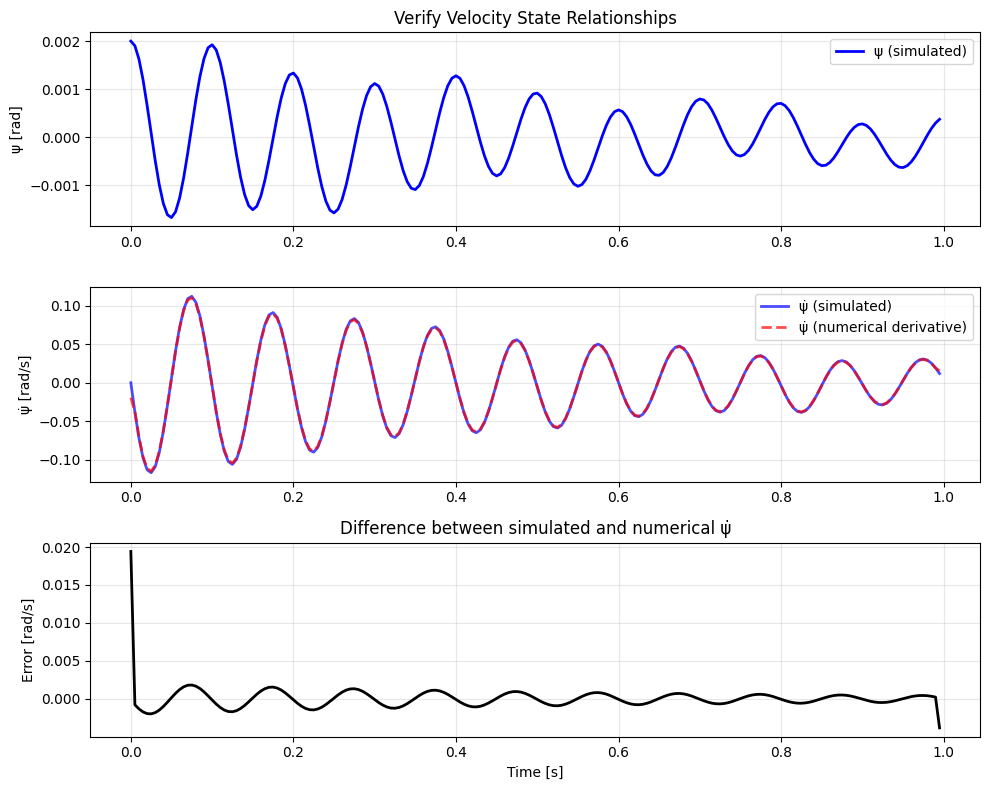


ψ̇ Comparison Statistics:
  Max simulated ψ̇:     1.1722e-01 rad/s
  Max numerical ψ̇:     1.1525e-01 rad/s
  Max difference:       1.9413e-02 rad/s
  RMS difference:       1.6142e-03 rad/s
  Correlation:          0.999579


In [ ]:
print("\n" + "="*70)
print("1. VERIFY PSI_DOT FROM SIMULATION")
print("="*70)

# Compute psi_dot numerically from psi using finite differences
psi_dot_numerical = np.gradient(x_sim['psi'].values, t_sim)

# Compare with simulated psi_dot
psi_dot_simulated = x_sim['psi_dot'].values

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Psi
axes[0].plot(t_sim, x_sim['psi'], 'b-', linewidth=2, label='ψ (simulated)')
axes[0].set_ylabel('ψ [rad]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Verify Velocity State Relationships')

# Psi_dot comparison
axes[1].plot(t_sim, psi_dot_simulated, 'b-', linewidth=2, label='ψ̇ (simulated)', alpha=0.7)
axes[1].plot(t_sim, psi_dot_numerical, 'r--', linewidth=2, label='ψ̇ (numerical derivative)', alpha=0.7)
axes[1].set_ylabel('ψ̇ [rad/s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error
axes[2].plot(t_sim, psi_dot_simulated - psi_dot_numerical, 'k-', linewidth=2)
axes[2].set_ylabel('Error [rad/s]')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Difference between simulated and numerical ψ̇')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nψ̇ Comparison Statistics:")
print(f"  Max simulated ψ̇:     {np.max(np.abs(psi_dot_simulated)):.4e} rad/s")
print(f"  Max numerical ψ̇:     {np.max(np.abs(psi_dot_numerical)):.4e} rad/s")
print(f"  Max difference:       {np.max(np.abs(psi_dot_simulated - psi_dot_numerical)):.4e} rad/s")
print(f"  RMS difference:       {np.sqrt(np.mean((psi_dot_simulated - psi_dot_numerical)**2)):.4e} rad/s")
print(f"  Correlation:          {np.corrcoef(psi_dot_simulated, psi_dot_numerical)[0,1]:.6f}")


###Check all velocity States


2. VERIFY ALL VELOCITY STATES


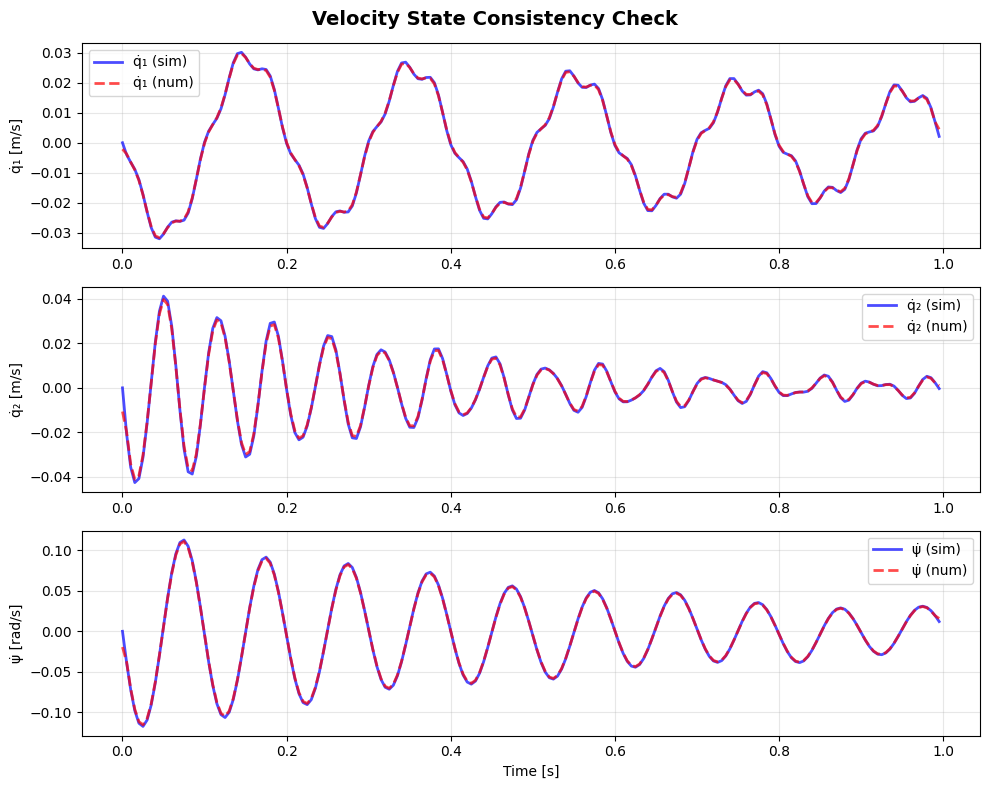


Velocity State Correlations:
  q̇₁: 0.999825
  q̇₂: 0.998412
  ψ̇:  0.999579


In [ ]:
print("\n" + "="*70)
print("2. VERIFY ALL VELOCITY STATES")
print("="*70)

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Q1 dot
q1_dot_numerical = np.gradient(x_sim['q1'].values, t_sim)
axes[0].plot(t_sim, x_sim['q1_dot'].values, 'b-', linewidth=2, label='q̇₁ (sim)', alpha=0.7)
axes[0].plot(t_sim, q1_dot_numerical, 'r--', linewidth=2, label='q̇₁ (num)', alpha=0.7)
axes[0].set_ylabel('q̇₁ [m/s]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q2 dot
q2_dot_numerical = np.gradient(x_sim['q2'].values, t_sim)
axes[1].plot(t_sim, x_sim['q2_dot'].values, 'b-', linewidth=2, label='q̇₂ (sim)', alpha=0.7)
axes[1].plot(t_sim, q2_dot_numerical, 'r--', linewidth=2, label='q̇₂ (num)', alpha=0.7)
axes[1].set_ylabel('q̇₂ [m/s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Psi dot
axes[2].plot(t_sim, psi_dot_simulated, 'b-', linewidth=2, label='ψ̇ (sim)', alpha=0.7)
axes[2].plot(t_sim, psi_dot_numerical, 'r--', linewidth=2, label='ψ̇ (num)', alpha=0.7)
axes[2].set_ylabel('ψ̇ [rad/s]')
axes[2].set_xlabel('Time [s]')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Velocity State Consistency Check', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nVelocity State Correlations:")
print(f"  q̇₁: {np.corrcoef(x_sim['q1_dot'].values, q1_dot_numerical)[0,1]:.6f}")
print(f"  q̇₂: {np.corrcoef(x_sim['q2_dot'].values, q2_dot_numerical)[0,1]:.6f}")
print(f"  ψ̇:  {np.corrcoef(psi_dot_simulated, psi_dot_numerical)[0,1]:.6f}")

###Check Measurement Noise Levels


3. MEASUREMENT NOISE SENSITIVITY ANALYSIS

Testing different noise levels:
--------------------------------------------------

CURRENT noise:
  Displacement: 2.00 mm, Angle: 0.573 deg
  q₁ EV:     1.19e-05
  q̇₁ EV:     5.16e+02
  ψ EV:      1.71e-04
  ψ̇ EV:      3.08e+04
  Ωₓ EV:     3.48e+07

LOWER noise:
  Displacement: 0.20 mm, Angle: 0.057 deg
  q₁ EV:     1.24e-07
  q̇₁ EV:     2.83e+01
  ψ EV:      1.71e-06
  ψ̇ EV:      3.78e+02
  Ωₓ EV:     3.77e+06

HIGHER noise:
  Displacement: 20.00 mm, Angle: 5.730 deg
  q₁ EV:     1.10e-03
  q̇₁ EV:     7.79e+03
  ψ EV:      1.70e-02
  ψ̇ EV:      2.67e+06
  Ωₓ EV:     8.66e+07

PERFECT noise:
  Displacement: 0.00 mm, Angle: 0.000 deg
  q₁ EV:     3.03e-20
  q̇₁ EV:     5.84e-12
  ψ EV:      1.72e-20
  ψ̇ EV:      1.10e-11
  Ωₓ EV:     9.27e-07


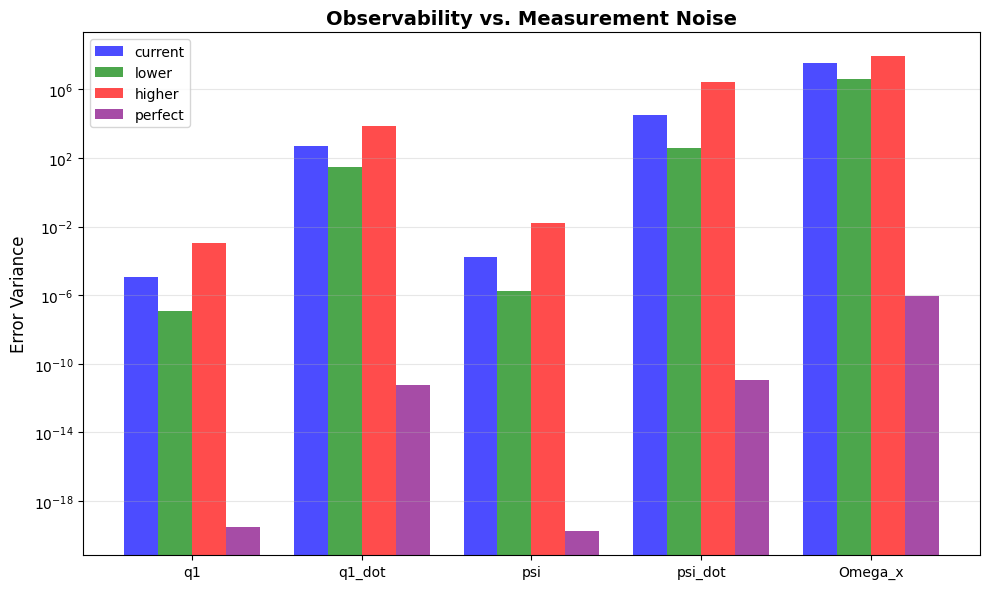

In [ ]:
print("\n" + "="*70)
print("3. MEASUREMENT NOISE SENSITIVITY ANALYSIS")
print("="*70)

# Try different noise levels
noise_levels = {
    'current': {'w_r1': 0.002, 'w_r2': 0.002, 'theta_r1': 0.01, 'theta_r2': 0.01},
    'lower': {'w_r1': 0.0002, 'w_r2': 0.0002, 'theta_r1': 0.001, 'theta_r2': 0.001},
    'higher': {'w_r1': 0.02, 'w_r2': 0.02, 'theta_r1': 0.1, 'theta_r2': 0.1},
    'perfect': {'w_r1': 1e-10, 'w_r2': 1e-10, 'theta_r1': 1e-10, 'theta_r2': 1e-10}
}

noise_results = {}

print("\nTesting different noise levels:")
print("-" * 50)

for noise_name, noise_stds in noise_levels.items():
    noise_vars = {key: val**2 for key, val in noise_stds.items()}

    # Recompute observability with new noise
    SFO_noise = pybounds.SlidingFisherObservability(
        SEOM.O_df_sliding,
        time=SEOM.t_sim,
        lam=1e-8,
        R=noise_vars,
        states=o_states,
        sensors=list(noise_stds.keys()),
        time_steps=o_time_steps,
        w=None
    )

    EV_noise = SFO_noise.get_minimum_error_variance()

    # Get average error variances
    avg_evs = {}
    for state in o_states:
        ev_state = EV_noise[state].values[np.isfinite(EV_noise[state].values)]
        avg_evs[state] = np.mean(ev_state)

    noise_results[noise_name] = avg_evs

    print(f"\n{noise_name.upper()} noise:")
    print(f"  Displacement: {noise_stds['w_r1']*1000:.2f} mm, Angle: {np.degrees(noise_stds['theta_r1']):.3f} deg")
    print(f"  q₁ EV:     {avg_evs['q1']:.2e}")
    print(f"  q̇₁ EV:     {avg_evs['q1_dot']:.2e}")
    print(f"  ψ EV:      {avg_evs['psi']:.2e}")
    print(f"  ψ̇ EV:      {avg_evs['psi_dot']:.2e}")
    print(f"  Ωₓ EV:     {avg_evs['Omega_x']:.2e}")

# Plot noise sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

states_to_plot = ['q1', 'q1_dot', 'psi', 'psi_dot', 'Omega_x']
x_positions = np.arange(len(states_to_plot))
width = 0.2

for i, (noise_name, color) in enumerate(zip(['current', 'lower', 'higher', 'perfect'],
                                              ['blue', 'green', 'red', 'purple'])):
    evs = [noise_results[noise_name][state] for state in states_to_plot]
    ax.bar(x_positions + i*width, evs, width, label=noise_name, color=color, alpha=0.7)

ax.set_yscale('log')
ax.set_xticks(x_positions + 1.5*width)
ax.set_xticklabels(states_to_plot)
ax.set_ylabel('Error Variance', fontsize=12)
ax.set_title('Observability vs. Measurement Noise', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# DIAGNOSE WHY q2 AND PSI AREN'T EXCITED
# ============================================================================

print("="*70)
print("DIAGNOSIS: WHY ARE q2 AND PSI BARELY MOVING?")
print("="*70)

# Check state amplitudes with the new (increased amplitude) simulation
print("\nState amplitudes:")
for state in ['q1', 'q2', 'psi', 'q1_dot', 'q2_dot', 'psi_dot']:
    state_range = np.ptp(x_sim[state].values)
    state_max = np.max(np.abs(x_sim[state].values))
    print(f"  {state:12s}: max={state_max:.4e}, range={state_range:.4e}")

# Check control amplitudes
print("\nControl amplitudes:")
for control in ['u1', 'u2', 'u3']:
    control_range = np.ptp(u_sim[control].values)
    print(f"  {control}: range={control_range:.4e}")

# Check coupling in dynamics
print("\n" + "="*70)
print("CONTROL COUPLING EFFECTIVENESS")
print("="*70)

print("\nHow u1 (flapping) affects each state:")
print(f"  α₁ = {params.alpha_1} → affects q̈₁")
print(f"  α₂ = {params.alpha_2} → affects q̈₂")
print(f"  Ratio α₂/α₁ = {params.alpha_2/params.alpha_1:.2f}")
print(f"\n  Expected: q₂ should be {params.alpha_2/params.alpha_1:.2f}× less excited than q₁")
print(f"  Actual:   q₂/q₁ = {np.max(np.abs(x_sim['q2'].values))/np.max(np.abs(x_sim['q1'].values)):.2f}")

print("\nHow u2 (twist) affects ψ:")
print(f"  βψ = {params.beta_psi} → affects ψ̈")
print(f"  u2 amplitude = {np.ptp(u_sim['u2'].values):.4f} rad")
print(f"  Expected ψ excitation: ~(βψ × u2_amp / ωψ²)")
print(f"    = {params.beta_psi * 0.1 / params.omega_psi**2:.6f} rad")
print(f"  Actual ψ amplitude: {np.max(np.abs(x_sim['psi'].values)):.6f} rad")

# Check natural frequencies
print("\n" + "="*70)
print("MODAL FREQUENCY ANALYSIS")
print("="*70)

print("\nNatural frequencies:")
print(f"  ω₁ = {params.omega_1/(2*np.pi):.1f} Hz (first bending)")
print(f"  ω₂ = {params.omega_2/(2*np.pi):.1f} Hz (second bending)")
print(f"  ωψ = {params.omega_psi/(2*np.pi):.1f} Hz (torsion)")

print(f"\nFlapping frequency: 25 Hz")
print(f"  Ratio to ω₁: {25.0 / (params.omega_1/(2*np.pi)):.2f}")
print(f"  Ratio to ω₂: {25.0 / (params.omega_2/(2*np.pi)):.2f}")
print(f"  → Flapping at {25.0 / (params.omega_2/(2*np.pi)):.2f}× second bending natural frequency")

print(f"\nTwist frequency: 3 Hz")
print(f"  Ratio to ωψ: {3.0 / (params.omega_psi/(2*np.pi)):.2f}")
print(f"  → Twisting at {3.0 / (params.omega_psi/(2*np.pi)):.2f}× torsional natural frequency")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

if np.max(np.abs(x_sim['q2'].values)) < 1e-4:
    print("\n❌ q₂ is still barely excited (< 0.1mm)")
    print("\nOptions:")
    print("  1. Increase α₂ from {:.1f} to ~50.0 (10× stronger)".format(params.alpha_2))
    print("  2. Change flapping frequency to match ω₂ (15 Hz) for resonance")
    print("  3. Accept that q₂ has weak excitation (document in report)")

if np.max(np.abs(x_sim['psi'].values)) < 1e-3:
    print("\n❌ ψ is still barely excited (< 1 mrad)")
    print("\nOptions:")
    print("  1. Increase βψ from {:.1f} to ~80.0 (10× stronger)".format(params.beta_psi))
    print("  2. Increase u2 amplitude from 0.1 to 0.5 rad")
    print("  3. Change twist frequency to match ωψ (10 Hz) for resonance")

DIAGNOSIS: WHY ARE q2 AND PSI BARELY MOVING?

State amplitudes:
  q1          : max=1.0000e-03, range=1.9385e-03
  q2          : max=5.0000e-04, range=9.4350e-04
  psi         : max=2.0000e-03, range=3.6744e-03
  q1_dot      : max=3.2061e-02, range=6.2242e-02
  q2_dot      : max=4.2552e-02, range=8.3754e-02
  psi_dot     : max=1.1722e-01, range=2.2979e-01

Control amplitudes:
  u1: range=1.0000e-01
  u2: range=2.0000e-01
  u3: range=1.0000e+00

CONTROL COUPLING EFFECTIVENESS

How u1 (flapping) affects each state:
  α₁ = 10.0 → affects q̈₁
  α₂ = 5.0 → affects q̈₂
  Ratio α₂/α₁ = 0.50

  Expected: q₂ should be 0.50× less excited than q₁
  Actual:   q₂/q₁ = 0.50

How u2 (twist) affects ψ:
  βψ = 8.0 → affects ψ̈
  u2 amplitude = 0.2000 rad
  Expected ψ excitation: ~(βψ × u2_amp / ωψ²)
    = 0.000203 rad
  Actual ψ amplitude: 0.002000 rad

MODAL FREQUENCY ANALYSIS

Natural frequencies:
  ω₁ = 5.0 Hz (first bending)
  ω₂ = 15.0 Hz (second bending)
  ωψ = 10.0 Hz (torsion)

Flapping frequen

###Test Psi_dot as a measurement


4. TEST PSI_DOT AS A DIRECT MEASUREMENT

Recomputing observability with ψ̇ as a direct measurement...
(This may take a moment...)

COMPARISON: WITH vs WITHOUT PSI_DOT MEASUREMENT

State        Without ψ̇      With ψ̇         Improvement    
------------------------------------------------------------
q1           1.24e-07        1.08e-05        0.01           x
q1_dot       2.81e+01        2.27e+02        0.12           x
psi          1.71e-06        1.65e-04        0.01           x
psi_dot      3.78e+02        9.76e-03        38718.63       x
Omega_x      3.75e+06        1.62e+07        0.23           x
Omega_y      4.27e+06        1.08e+07        0.39           x


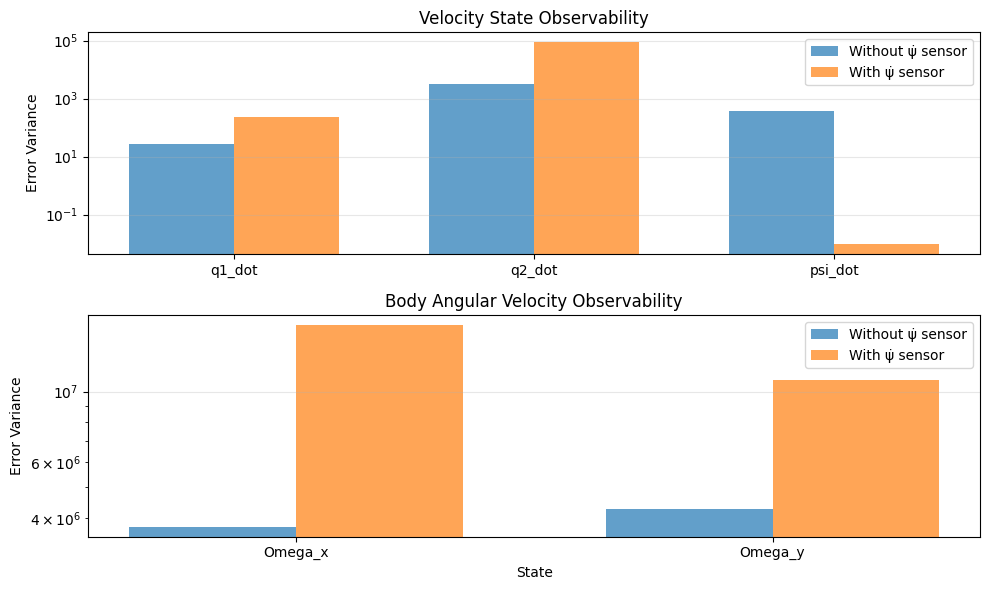


4b. TEST PSI_DOT AS THE **ONLY** MEASUREMENT

Computing observability with ONLY ψ̇ measurement...

Observability matrix shape with only ψ̇: (6, 8)
Rank: 6/8
✗ System is NOT fully observable from ψ̇ alone
  Can observe 6 out of 8 states

States in observability matrix:
['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']

First observability matrix (first 8 rows):
                         q1    q1_dot        q2    q2_dot       psi   psi_dot  \
sensor  time_step                                                               
psi_dot 0          0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
        1          0.000008  0.000054  0.000020 -0.000020  0.256724  0.207943   
        2         -0.001414  0.000057  0.000266 -0.000012  0.106756  0.043089   
        3         -0.002618 -0.000223  0.000376 -0.000097  0.033701  0.008882   
        4         -0.003300 -0.000163  0.000080 -0.000062  0.009322  0.001901   
        5         -0.002903 -0.000033  0.00000

In [ ]:
print("\n" + "="*70)
print("4. TEST PSI_DOT AS A DIRECT MEASUREMENT")
print("="*70)

# Modify measurement function to include psi_dot
def measurement_function_with_psi_dot(t, x, params, return_measurement_names=False):
    """Measurement function that includes psi_dot"""
    if return_measurement_names:
        return ['w_r1', 'w_r2', 'theta_r1', 'theta_r2', 'psi_dot']

    q1 = x['q1']
    q2 = x['q2']
    psi = x['psi']
    psi_dot = x['psi_dot']

    # Compute sensor locations
    r1 = params.r_base_1 * params.L + params.eta_q * q1 + params.eta_psi * psi
    r2 = params.r_base_2 * params.L + params.eta_q * q2 + params.eta_psi * psi
    r1 = np.clip(r1, 0.1 * params.L, 0.9 * params.L)
    r2 = np.clip(r2, 0.1 * params.L, 0.9 * params.L)

    # Mode shapes
    r_norm = np.array([r1, r2]) / params.L
    phi1 = r_norm
    phi2 = r_norm**2 - 0.5 * r_norm
    phi_psi = r_norm

    y = {}
    y['w_r1'] = phi1[0]*q1 + phi2[0]*q2 + params.kappa_1*psi*q1
    y['w_r2'] = phi1[1]*q1 + phi2[1]*q2 + params.kappa_2*psi*q2
    y['theta_r1'] = phi_psi[0] * psi
    y['theta_r2'] = phi_psi[1] * psi
    y['psi_dot'] = psi_dot  # DIRECT MEASUREMENT OF PSI_DOT

    return y

# Create new simulator with psi_dot measurement
class FloppyPlateSimulatorWithPsiDot(FloppyPlateSimulator):
    def __init__(self, params):
        super().__init__(params)
        self.measurement_names = ['w_r1', 'w_r2', 'theta_r1', 'theta_r2', 'psi_dot']

    def h(self, t, x, aux=None):
        return measurement_function_with_psi_dot(t, x, self.params)

simulator_psi_dot = FloppyPlateSimulatorWithPsiDot(params)

print("\nRecomputing observability with ψ̇ as a direct measurement...")
print("(This may take a moment...)")

# Recompute observability matrix with NEW simulator
# Important: We're using the SAME state trajectory but with a DIFFERENT measurement function
SEOM_psi_dot = pybounds.SlidingEmpiricalObservabilityMatrix(
    simulator_psi_dot, t_sim, x_sim, u_sim,
    w=w, eps=1e-4
)

# Define noise for psi_dot measurement (assume it's like angular velocity from gyro)
measurement_noise_stds_psi_dot = {
    'w_r1': 0.002,
    'w_r2': 0.002,
    'theta_r1': 0.01,
    'theta_r2': 0.01,
    'psi_dot': 0.1  # Angular velocity noise (rad/s) - typical gyro noise
}

noise_vars_psi_dot = {key: val**2 for key, val in measurement_noise_stds_psi_dot.items()}

# Compute Fisher observability
SFO_psi_dot = pybounds.SlidingFisherObservability(
    SEOM_psi_dot.O_df_sliding,
    time=SEOM_psi_dot.t_sim,
    lam=1e-8,
    R=noise_vars_psi_dot,
    states=o_states,
    sensors=list(noise_vars_psi_dot.keys()),
    time_steps=o_time_steps,
    w=None
)

EV_psi_dot = SFO_psi_dot.get_minimum_error_variance()

# Compare results
print("\n" + "="*70)
print("COMPARISON: WITH vs WITHOUT PSI_DOT MEASUREMENT")
print("="*70)

comparison_states = ['q1', 'q1_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']

print(f"\n{'State':<12} {'Without ψ̇':<15} {'With ψ̇':<15} {'Improvement':<15}")
print("-" * 60)

for state in comparison_states:
    ev_without = np.mean(EV_no_nan[state].values[np.isfinite(EV_no_nan[state].values)])
    ev_with = np.mean(EV_psi_dot[state].values[np.isfinite(EV_psi_dot[state].values)])
    improvement = ev_without / ev_with

    print(f"{state:<12} {ev_without:<15.2e} {ev_with:<15.2e} {improvement:<15.2f}x")

# Visualize the improvement
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Compare observability for velocity states
vel_states = ['q1_dot', 'q2_dot', 'psi_dot']
x_pos = np.arange(len(vel_states))
width = 0.35

ev_without_list = [np.mean(EV_no_nan[s].values[np.isfinite(EV_no_nan[s].values)]) for s in vel_states]
ev_with_list = [np.mean(EV_psi_dot[s].values[np.isfinite(EV_psi_dot[s].values)]) for s in vel_states]

axes[0].bar(x_pos - width/2, ev_without_list, width, label='Without ψ̇ sensor', alpha=0.7)
axes[0].bar(x_pos + width/2, ev_with_list, width, label='With ψ̇ sensor', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(vel_states)
axes[0].set_ylabel('Error Variance')
axes[0].set_title('Velocity State Observability')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Compare for body angular velocities
body_states = ['Omega_x', 'Omega_y']
x_pos = np.arange(len(body_states))

ev_without_list = [np.mean(EV_no_nan[s].values[np.isfinite(EV_no_nan[s].values)]) for s in body_states]
ev_with_list = [np.mean(EV_psi_dot[s].values[np.isfinite(EV_psi_dot[s].values)]) for s in body_states]

axes[1].bar(x_pos - width/2, ev_without_list, width, label='Without ψ̇ sensor', alpha=0.7)
axes[1].bar(x_pos + width/2, ev_with_list, width, label='With ψ̇ sensor', alpha=0.7)
axes[1].set_yscale('log')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(body_states)
axes[1].set_ylabel('Error Variance')
axes[1].set_xlabel('State')
axes[1].set_title('Body Angular Velocity Observability')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ============================================================================
# 4b. TEST PSI_DOT AS THE ONLY MEASUREMENT
# ============================================================================

print("\n" + "="*70)
print("4b. TEST PSI_DOT AS THE **ONLY** MEASUREMENT")
print("="*70)

# Create measurement function with ONLY psi_dot
def measurement_function_only_psi_dot(t, x, params, return_measurement_names=False):
    """Measurement function with ONLY psi_dot"""
    if return_measurement_names:
        return ['psi_dot']

    psi_dot = x['psi_dot']

    y = {}
    y['psi_dot'] = psi_dot

    return y

class FloppyPlateSimulatorOnlyPsiDot(FloppyPlateSimulator):
    def __init__(self, params):
        super().__init__(params)
        self.measurement_names = ['psi_dot']

    def h(self, t, x, aux=None):
        return measurement_function_only_psi_dot(t, x, self.params)

simulator_only_psi_dot = FloppyPlateSimulatorOnlyPsiDot(params)

print("\nComputing observability with ONLY ψ̇ measurement...")

# Compute observability
SEOM_only_psi_dot = pybounds.SlidingEmpiricalObservabilityMatrix(
    simulator_only_psi_dot, t_sim, x_sim, u_sim,
    w=w, eps=1e-4
)

# Check observability matrix
O_only_psi_dot = SEOM_only_psi_dot.O_df_sliding[0]
print(f"\nObservability matrix shape with only ψ̇: {O_only_psi_dot.shape}")
print(f"Rank: {np.linalg.matrix_rank(O_only_psi_dot.values)}/{len(o_states)}")

if np.linalg.matrix_rank(O_only_psi_dot.values) == len(o_states):
    print("✓ System IS observable from ψ̇ alone!")
else:
    print("✗ System is NOT fully observable from ψ̇ alone")
    print(f"  Can observe {np.linalg.matrix_rank(O_only_psi_dot.values)} out of {len(o_states)} states")

# Show which states are in the observability matrix
print(f"\nStates in observability matrix:")
print(O_only_psi_dot.columns.tolist())

# Show first few rows
print(f"\nFirst observability matrix (first 8 rows):")
print(O_only_psi_dot.head(8))

###Test without PSI control input (no u2)


5. TEST WITHOUT TORSIONAL CONTROL INPUT (u₂)


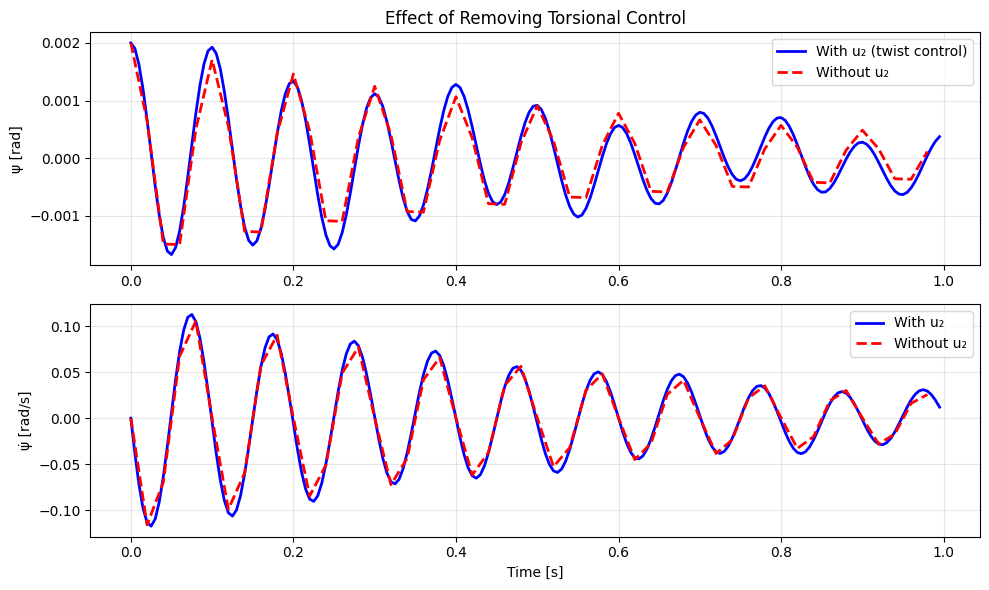


ψ Amplitude Comparison:
  With u₂:    2.0000e-03 rad
  Without u₂: 2.0000e-03 rad

ψ̇ Amplitude Comparison:
  With u₂:    1.1722e-01 rad/s
  Without u₂: 1.1584e-01 rad/s


In [ ]:
print("\n" + "="*70)
print("5. TEST WITHOUT TORSIONAL CONTROL INPUT (u₂)")
print("="*70)

# Simulate without u2 (no twist control)
def control_inputs_no_u2(t: float) -> np.ndarray:
    """Control inputs WITHOUT twist excitation"""
    amp_flap, freq_flap = 0.01, 25.0
    amp_body, freq_body = 0.5, 2.0
    u1 = amp_flap * np.sin(2 * np.pi * freq_flap * t)
    u2 = 0.0  # NO TWIST CONTROL
    u3 = amp_body * np.sin(2 * np.pi * freq_body * t)
    return np.array([u1, u2, u3])

# Run simulation without u2
def simulate_no_u2():
    t_span = (0.0, 1.0)
    t_eval = np.arange(0, 1.0, 0.02)
    x0 = np.array([0.001, 0.0, 0.0005, 0.0, 0.002, 0.0, 0.0, 0.0])

    def dynamics_no_u2(t, x_arr):
        u = control_inputs_no_u2(t)
        q1, q1_dot, q2, q2_dot, psi, psi_dot, Omega_x, Omega_y = x_arr

        w1, w2, wp = params.omega_1, params.omega_2, params.omega_psi
        z1, z2, zp = params.zeta_1, params.zeta_2, params.zeta_psi
        k1, k2, kp = params.k_1, params.k_2, params.k_psi
        gx, gy = params.gamma_x, params.gamma_y

        Omega_squared = Omega_x**2 + Omega_y**2

        f = np.zeros(8)
        f[0] = q1_dot
        f[1] = -w1**2*q1 - 2*z1*w1*q1_dot + k1*Omega_squared*q1 + k1*Omega_x*psi_dot + params.alpha_1*u[0]
        f[2] = q2_dot
        f[3] = -w2**2*q2 - 2*z2*w2*q2_dot + k2*Omega_squared*q2 + k2*Omega_y*psi_dot + params.alpha_2*u[0]
        f[4] = psi_dot
        f[5] = -wp**2*psi - 2*zp*wp*psi_dot + kp*Omega_x*q1_dot + kp*Omega_y*q2_dot + params.beta_psi*u[1]
        f[6] = -gx*Omega_x + params.rho_Omega*u[2]
        f[7] = -gy*Omega_y + params.rho_Omega*u[2]
        return f

    sol = solve_ivp(dynamics_no_u2, t_span, x0, t_eval=t_eval, method='RK45')

    state_names = ['q1', 'q1_dot', 'q2', 'q2_dot', 'psi', 'psi_dot', 'Omega_x', 'Omega_y']
    x_sim_no_u2 = pd.DataFrame(sol.y.T, columns=state_names)

    u_arr = np.array([control_inputs_no_u2(ti) for ti in sol.t])
    u_sim_no_u2 = pd.DataFrame(u_arr, columns=['u1', 'u2', 'u3'])

    return sol.t, x_sim_no_u2, u_sim_no_u2

t_no_u2, x_no_u2, u_no_u2 = simulate_no_u2()

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(t_sim, x_sim['psi'], 'b-', linewidth=2, label='With u₂ (twist control)')
axes[0].plot(t_no_u2, x_no_u2['psi'], 'r--', linewidth=2, label='Without u₂')
axes[0].set_ylabel('ψ [rad]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Effect of Removing Torsional Control')

axes[1].plot(t_sim, x_sim['psi_dot'], 'b-', linewidth=2, label='With u₂')
axes[1].plot(t_no_u2, x_no_u2['psi_dot'], 'r--', linewidth=2, label='Without u₂')
axes[1].set_ylabel('ψ̇ [rad/s]')
axes[1].set_xlabel('Time [s]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nψ Amplitude Comparison:")
print(f"  With u₂:    {np.max(np.abs(x_sim['psi'])):.4e} rad")
print(f"  Without u₂: {np.max(np.abs(x_no_u2['psi'])):.4e} rad")
print(f"\nψ̇ Amplitude Comparison:")
print(f"  With u₂:    {np.max(np.abs(x_sim['psi_dot'])):.4e} rad/s")
print(f"  Without u₂: {np.max(np.abs(x_no_u2['psi_dot'])):.4e} rad/s")